# Uso de Técnicas de Aprendizado de Máquina para a Predição do Tempo de Graduação dos Discentes de Engenharia da Computação na Região Sul do Brasil

## Importação das bibliotecas

In [3]:
import pandas as pd
import numpy as np
import glob
import os

## Importação da base de dados

In [5]:
caminho_diretorio = r"Microdados_Enade_2023\DADOS"

# Buscar todos os arquivos .csv com padrão especificado
arquivos = glob.glob(os.path.join(caminho_diretorio, "microdados2023_arq*.csv"))

dfs = []
colunas_existentes = set()

for arquivo in arquivos:
    df = pd.read_csv(arquivo, delimiter=";", encoding="latin1", low_memory=False)
    
    # Filtra apenas colunas ainda não adicionadas
    colunas_novas = [col for col in df.columns if col not in colunas_existentes]
    
    if colunas_novas:
        dfs.append(df[colunas_novas])
        colunas_existentes.update(colunas_novas)

# Concatena os dados horizontalmente (colunas diferentes, mesmas linhas)
df = pd.concat(dfs, axis=1)

# Filtrar por curso e região
df = df[
    (df["CO_GRUPO"] == 6411) & 
    (df["CO_REGIAO_CURSO"] == 4)
]

# Salva resultado
# df_final.to_csv(os.path.join(caminho_diretorio, "base_final.csv"), index=False, sep=";")

## Análise exploratória
### Amostra inicial

In [7]:
df.head()

,NU_ANO,CO_CURSO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,...,QE_I64,QE_I65,QE_I66,QE_I67,QE_I68,TP_SEXO,NU_IDADE,QE_I01,QE_I02,QE_I03
4360,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN
4361,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN
4362,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN
4363,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN
4364,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN


### Informações da base de dados

In [9]:
def info_completo(df):
    tabela = pd.DataFrame({
        'Tipo': df.dtypes,
        'Não Nulos': df.notnull().sum(),
        'Nulos': df.isnull().sum(),
        'Únicos': df.nunique()
    })
    display(tabela)
info_completo(df)

,Tipo,Não Nulos,Nulos,Únicos
NU_ANO,int64,887,0,1
CO_CURSO,int64,887,0,33
CO_IES,int64,887,0,26
CO_CATEGAD,int64,887,0,4
CO_ORGACAD,int64,887,0,4
...,...,...,...,...
TP_SEXO,object,887,0,2
NU_IDADE,int64,887,0,16
QE_I01,object,865,22,3
QE_I02,object,865,22,4


### Resumo estatístico das variáveis

In [11]:
df.describe()

,NU_ANO,CO_CURSO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,...,QE_I60,QE_I61,QE_I62,QE_I63,QE_I64,QE_I65,QE_I66,QE_I67,QE_I68,NU_IDADE
count,887.0,8.870000e+02,887.000000,887.000000,887.000000,887.0,887.000000,8.870000e+02,887.000000,887.0,...,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.00000,887.000000
mean,2023.0,8.892754e+05,1312.740699,3.216460,10025.001127,6411.0,0.684329,4.158298e+06,41.492672,4.0,...,5.350289,5.408092,5.262428,5.357225,5.611561,5.627746,5.619653,5.166474,5.42659,27.862458
std,0.0,5.532997e+05,1667.231131,2.391303,3.822087,0.0,0.465045,7.715309e+04,0.770288,0.0,...,1.204189,1.121622,1.286247,1.201184,0.917603,0.984918,0.896150,1.510774,1.23584,4.741777
min,2023.0,8.720000e+02,10.000000,1.000000,10020.000000,6411.0,0.000000,4.101408e+06,41.000000,4.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,21.000000
25%,2023.0,1.156160e+05,588.000000,1.000000,10020.000000,6411.0,0.000000,4.106902e+06,41.000000,4.0,...,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.00000,25.000000
50%,2023.0,1.155374e+06,588.000000,4.000000,10028.000000,6411.0,1.000000,4.106902e+06,41.000000,4.0,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,26.000000
75%,2023.0,1.315345e+06,1491.000000,4.000000,10028.000000,6411.0,1.000000,4.204202e+06,42.000000,4.0,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,30.000000
max,2023.0,1.537513e+06,14951.000000,8.000000,10028.000000,6411.0,1.000000,4.321808e+06,43.000000,4.0,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,50.000000


## Tratamento dos dados

### Apagar registro de formandos que faltaram ao dia de aplicação do ENADE.

In [14]:
df = df[df["TP_PRES"] == 555]
df.shape

(865, 125)

### Criar informação de faixa etária

In [16]:
df['NU_IDADE'] = pd.cut(df['NU_IDADE'], bins=[0, 29, float('inf')], labels=[0, 1])

### Criar classificação para o tempo de conclusão do EM

In [18]:
df['CLAS_FIM_EM'] = np.where(df['ANO_FIM_EM'] <= 2016, 1, 2)

## Apagando colunas consideradas desnecessárias

In [20]:
df = df.drop(columns=[
    'NU_ANO', 'CO_GRUPO', 'CO_MUNIC_CURSO', 'CO_REGIAO_CURSO',
    'NU_ITEM_OFG', 'NU_ITEM_OFG_Z', 'NU_ITEM_OFG_X', 'NU_ITEM_OFG_N',
    'NU_ITEM_OCE', 'NU_ITEM_OCE_Z', 'NU_ITEM_OCE_X', 'NU_ITEM_OCE_N',
    'DS_VT_GAB_OFG_FIN', 'DS_VT_GAB_OCE_FIN', 'DS_VT_ESC_OFG', 'DS_VT_ACE_OFG',
    'DS_VT_ESC_OCE', 'DS_VT_ACE_OCE', 'TP_PRES', 'TP_PR_GER', 'TP_PR_OB_FG',
    'TP_PR_DI_FG', 'TP_PR_OB_CE', 'TP_PR_DI_CE', 'TP_SFG_D1', 'TP_SCE_D1'
])

### Discretização das variáveis de notas

In [22]:
# Lista de colunas a discretizar
cols = [
    'NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG',
    'NT_FG_D1', 'NT_FG_D1_PT', 'NT_FG_D1_CT',
    'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1'
]

# Função de discretização simples (quebra em 5 faixas)
def discretize_score(val):
    if pd.isna(val):
        return np.nan
    elif val < 20:
        return 0
    elif val < 40:
        return 1
    elif val < 60:
        return 2
    elif val < 80:
        return 3
    else:
        return 4

# Aplicar discretização
for col in cols:
    df[col] = df[col].apply(discretize_score)

### Criar classificação para tempo de formação

In [24]:
df["ANOS_CURS"] = 2023 - df["ANO_IN_GRAD"]
df["ANOS_CURS"] = pd.cut(df["ANOS_CURS"], bins=[-float('inf'), 5, float('inf')], labels=[1, 2]).astype(int)

### Informações do dataset final

In [26]:
info_completo(df)

,Tipo,Não Nulos,Nulos,Únicos
CO_CURSO,int64,865,0,32
CO_IES,int64,865,0,25
CO_CATEGAD,int64,865,0,4
CO_ORGACAD,int64,865,0,4
CO_MODALIDADE,int64,865,0,2
...,...,...,...,...
QE_I01,object,865,0,3
QE_I02,object,865,0,4
QE_I03,object,865,0,1
CLAS_FIM_EM,int32,865,0,2


In [27]:
df.head()

,CO_CURSO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_MODALIDADE,CO_UF_CURSO,QE_I04,QE_I05,QE_I06,QE_I07,...,QE_I66,QE_I67,QE_I68,TP_SEXO,NU_IDADE,QE_I01,QE_I02,QE_I03,CLAS_FIM_EM,ANOS_CURS
111101,64822,14,8,10028,1,43,B,C,B,B,...,6.0,6.0,6.0,F,0,A,A,A,1,1
111102,64822,14,8,10028,1,43,B,C,B,B,...,1.0,1.0,6.0,F,0,A,A,A,1,1
111103,64822,14,8,10028,1,43,B,C,B,B,...,5.0,5.0,6.0,F,0,A,A,A,1,1
111104,64822,14,8,10028,1,43,B,C,B,B,...,5.0,5.0,5.0,F,0,A,A,A,1,2
111105,64822,14,8,10028,1,43,B,C,B,B,...,5.0,5.0,5.0,F,0,A,A,A,1,1


### Aplicar algoritmo kBest

In [29]:

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# categorical_cols = df.select_dtypes(include='object').columns

# for col in categorical_cols:
#     df[col] = le.fit_transform(df[col].astype(str))


# categorical_cols = df.select_dtypes(include='object').columns

# # Supondo que sua variável alvo seja 'target' e as features estão no restante das colunas
# X = df.drop('ANOS_CURS', axis=1)  # Remova a coluna alvo
# y = df['ANOS_CURS']  # Variável alvo

# # Aplicando o SelectKBest com o teste chi2
# kbest = SelectKBest(score_func=chi2, k=10)  # Seleciona as 5 melhores variáveis

# # Ajustando o modelo e transformando as features
# X_kbest = kbest.fit_transform(X, y)

# # Visualizar as colunas selecionadas
# selected_columns = X.columns[kbest.get_support()]
# print(f'Colunas selecionadas: {selected_columns}')



## Aplicando PCA

In [31]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Codificação de variáveis categóricas
le = LabelEncoder()
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Separando features e alvo
X = df.drop('ANOS_CURS', axis=1)
y = df['ANOS_CURS']

# Padronização dos dados (necessária para PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicando PCA para reduzir para 10 componentes
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Exibir a variância explicada por cada componente
print(f'Variância explicada por cada componente: {pca.explained_variance_ratio_}')
print(f'Soma da variância explicada: {sum(pca.explained_variance_ratio_):.2f}')


Variância explicada por cada componente: [0.27531735 0.13397023 0.05528464 0.04621179 0.03620676 0.02956787
 0.02216266 0.02140226 0.01891949 0.01709174]
Soma da variância explicada: 0.66


### Aplicando o CatBoost sem balanceamento e com K-Best

In [33]:
#Instalando o CatBoost
# import sys
# !{sys.executable} -m pip install catboost


In [34]:
# from catboost import CatBoostClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report

# # Lista de variáveis selecionadas
# selected_cols = ['CO_CURSO', 'CO_IES', 'QE_I06', 'QE_I08', 'QE_I10', 'QE_I11', 'QE_I17',
#        'QE_I22', 'NU_IDADE', 'QE_I02']

# # Separar X e y
# X = df[selected_cols]
# y = df['ANOS_CURS']  # Substitua 'target' pelo nome real da sua variável alvo

# # Dividir treino e teste
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42, stratify=y
# )

# # Criar e treinar o modelo CatBoost
# model = CatBoostClassifier(
#     iterations=500,
#     learning_rate=0.1,
#     depth=6,
#     eval_metric='Accuracy',
#     verbose=0
# )

# # Treinar o modelo
# model.fit(X_train, y_train, cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Todas as colunas são categóricas

# # Fazer previsões
# y_pred = model.predict(X_test)

# # Avaliar o modelo
# print(classification_report(y_test, y_pred))


In [35]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Gerar a matriz de confusão
# cm = confusion_matrix(y_test, y_pred)

# # Exibir a matriz de confusão
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
# plt.title("MC do CatBoost")
# plt.show()


### CatBoost com SMOTE e K-Best

In [37]:
# from catboost import CatBoostClassifier
# from sklearn.model_selection import GridSearchCV, KFold, train_test_split
# from sklearn.metrics import classification_report
# from sklearn.preprocessing import OrdinalEncoder
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline

# # Colunas selecionadas
# selected_cols = ['CO_CURSO', 'CO_IES', 'QE_I06', 'QE_I08', 'QE_I10', 'QE_I11', 'QE_I17',
#        'QE_I22', 'NU_IDADE', 'QE_I02']
# X = df[selected_cols]
# y = df['ANOS_CURS']

# # Codificar variáveis categóricas
# encoder = OrdinalEncoder()
# X_encoded = encoder.fit_transform(X)

# # Dividir dados em treino e teste
# X_train, X_test, y_train, y_test = train_test_split(
#     X_encoded, y, test_size=0.3, random_state=42, stratify=y
# )

# # Modelo base
# catboost_model = CatBoostClassifier(verbose=0, eval_metric='Accuracy')

# # Grid de hiperparâmetros
# param_grid = {
#     'classifier__learning_rate': [0.1, 0.01, 0.001, 0.0001],
#     'classifier__iterations': [50, 100, 200, 300],
#     'classifier__depth': [2, 5, 10, 16]
# }

# # Pipeline com SMOTE e CatBoost
# pipeline = ImbPipeline(steps=[
#     ('smote', SMOTE(k_neighbors=1, random_state=42)),
#     ('classifier', catboost_model)
# ])

# # Validação cruzada com KFold
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# # Grid Search com Cross-Validation
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     cv=kfold,
#     scoring='accuracy',
#     n_jobs=-1
# )

# # Executar Grid Search
# grid_search.fit(X_train, y_train)

# # Melhor modelo
# best_model = grid_search.best_estimator_

# # Previsões no conjunto de teste
# y_pred = best_model.predict(X_test)

# # Resultados
# print("Melhores parâmetros encontrados:", grid_search.best_params_)
# print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


In [38]:
# # Aplicar SMOTE separadamente para ver o balanceamento
# smote = SMOTE(k_neighbors=1, random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# # Mostrar informações sobre o balanceamento
# from collections import Counter
# print("Distribuição original:", Counter(y_train))
# print("Distribuição após SMOTE:", Counter(y_resampled))

# # Número de amostras geradas:
# num_generated = len(X_resampled) - len(X_train)
# print("Total de registros gerados pelo SMOTE:", num_generated)


In [39]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Gerar a matriz de confusão
# cm = confusion_matrix(y_test, y_pred)

# # Exibir a matriz de confusão
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
# plt.title("MC do CatBoost com SMOTE")
# plt.show()


### Catboost com pca

In [41]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Pré-processamento
le = LabelEncoder()
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Separar X e y
X = df.drop('ANOS_CURS', axis=1)
y = df['ANOS_CURS']

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, random_state=42, stratify=y
)

# Criar e treinar o modelo CatBoost
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    verbose=0
)

model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.89      0.97      0.93       226
           2       0.50      0.18      0.26        34

    accuracy                           0.87       260
   macro avg       0.69      0.57      0.59       260
weighted avg       0.84      0.87      0.84       260



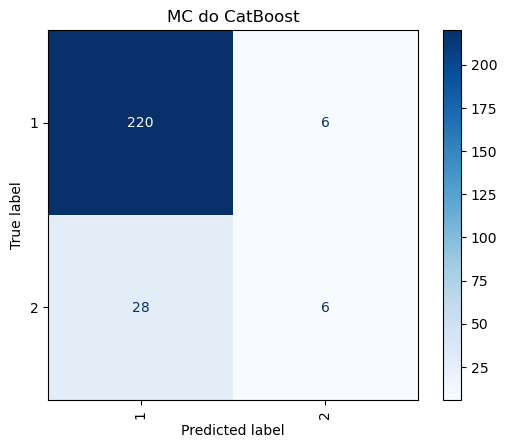

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão graficamente
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("MC do CatBoost")
plt.show()


### CatBoost com SMOTE e PCA

In [47]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd

# Codificação de variáveis categóricas
le = LabelEncoder()
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Separar X e y
X = df.drop('ANOS_CURS', axis=1)
y = df['ANOS_CURS']

# Padronização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA (antes da divisão para não aplicar fit em dados de teste)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, random_state=42, stratify=y
)

# Modelo base
catboost_model = CatBoostClassifier(verbose=0, eval_metric='Accuracy')

# Grid de hiperparâmetros
param_grid = {
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__iterations': [50, 100, 200],
    'classifier__depth': [2, 5, 10]
}

# Pipeline com SMOTE e CatBoost (PCA já foi aplicado antes)
pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(k_neighbors=1, random_state=42)),
    ('classifier', catboost_model)
])

# Validação cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1
)

# Treinar o modelo
grid_search.fit(X_train, y_train)

# Melhor modelo
best_model = grid_search.best_estimator_

# Prever no teste
y_pred = best_model.predict(X_test)

# Resultados
print("Melhores parâmetros encontrados:", grid_search.best_params_)
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Melhores parâmetros encontrados: {'classifier__depth': 5, 'classifier__iterations': 200, 'classifier__learning_rate': 0.1}

Relatório de Classificação:
               precision    recall  f1-score   support

           1       0.90      0.91      0.91       226
           2       0.36      0.35      0.36        34

    accuracy                           0.83       260
   macro avg       0.63      0.63      0.63       260
weighted avg       0.83      0.83      0.83       260



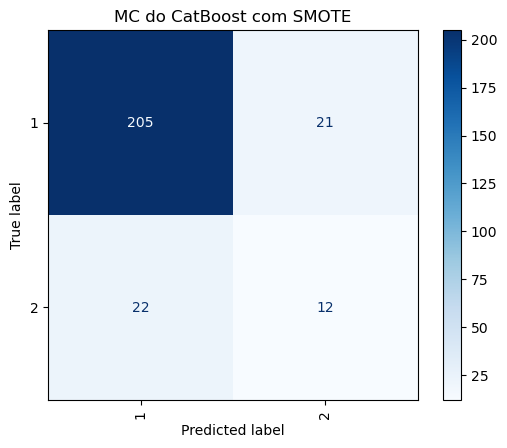

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão graficamente
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("MC do CatBoost com SMOTE")
plt.show()


In [57]:
# Aplicar SMOTE separadamente para ver o balanceamento
smote = SMOTE(k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Mostrar informações sobre o balanceamento
from collections import Counter
print("Distribuição original:", Counter(y_train))
print("Distribuição após SMOTE:", Counter(y_resampled))

# Número de amostras geradas:
num_generated = len(X_resampled) - len(X_train)
print("Total de registros gerados pelo SMOTE:", num_generated)


Distribuição original: Counter({1: 527, 2: 78})
Distribuição após SMOTE: Counter({1: 527, 2: 527})
Total de registros gerados pelo SMOTE: 449


### Random Forest

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV, KFold, train_test_split
# from sklearn.metrics import classification_report
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.decomposition import PCA
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline

# # Codificação de variáveis categóricas
# le = LabelEncoder()
# categorical_cols = df.select_dtypes(include='object').columns
# for col in categorical_cols:
#     df[col] = le.fit_transform(df[col].astype(str))

# # Separar X e y
# X = df.drop('ANOS_CURS', axis=1)
# y = df['ANOS_CURS']

# # Padronização dos dados
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Aplicar PCA
# pca = PCA(n_components=10)
# X_pca = pca.fit_transform(X_scaled)

# # Dividir dados em treino e teste
# X_train, X_test, y_train, y_test = train_test_split(
#     X_pca, y, test_size=0.3, random_state=42, stratify=y
# )

# # Modelo base: Random Forest
# rf_model = RandomForestClassifier(random_state=42)

# # Grid de hiperparâmetros
# param_grid = {
#     'classifier__n_estimators': [100, 200, 300],
#     'classifier__max_depth': [None, 10, 20],
#     'classifier__min_samples_split': [2, 5],
#     'classifier__min_samples_leaf': [1, 2],
#     'classifier__class_weight': ['balanced', None]  # Ajuste de pesos para lidar com desbalanceamento
# }

# # Pipeline com SMOTE e Random Forest
# pipeline = ImbPipeline(steps=[
#     ('smote', SMOTE(k_neighbors=1, random_state=42)),
#     ('classifier', rf_model)
# ])

# # Validação cruzada com KFold
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# # Grid Search com Cross-Validation
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     cv=kfold,
#     scoring='accuracy',
#     n_jobs=-1
# )

# # Treinando o modelo
# grid_search.fit(X_train, y_train)

# # Melhor modelo
# best_model = grid_search.best_estimator_

# # Previsões no conjunto de teste
# y_pred = best_model.predict(X_test)

# # Resultados
# print("Melhores parâmetros encontrados:", grid_search.best_params_)
# print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
